## Выполнили: Богославская Анна, Староверова Анна

In [1]:
# !pip install fastparquet
# !pip install --upgrade scikit-learn
# !pip install imblearn

In [112]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import defaultdict

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

## ML 

Вам предстоить обучить модель классификации вредоносных смартконтрактов. Данная секция будет оцениваться в 7 баллов.
Бенчмарк для засчитывания модели:
- sklearn.metrics.f1_score(y_true, y_pred, *, labels=None, pos_label=1,average='binary', sample_weight=None, zero_division='warn')
- F-мера >= 0.6
- За каждые 0.05 в меньшую сторону от заданного бенчмарка - минус один балл.

Дано:
- Директория Data - в которой лежат данные для обучения
-  Директория Model - в которую вы должны будете сохранить вашу модель в удобном для
вас формате, было бы клево если это pickle, но тут как вам нравится :)


### 0. Исследование признаков

In [3]:
df = pd.read_parquet('malicious_contract_training_dataset_final.parquet', engine='fastparquet')

In [4]:
df.head()

,contract_address,contract_name,contract_etherscan_label,contract_tag,contract_creator,contract_creation_tx,creation_bytecode,decompiled_opcodes,malicious,contract_creator_tag,source,notes,contract_creator_etherscan_label,block
82965,0x04ae3226c80e8c04d35e6e56089345bdd06da6de,,,Multichain Exploiter 10,0x98f5b0a99f258a09403d965647ee9d53677914af,0xe962b06db95db1dedb8b1664bf93bb8816c0cfbd1876...,0x6080604052600180546001600160a01b03191673c02a...,PUSH1 0x80 PUSH1 0x40 MSTORE PUSH1 0x01 DUP1 S...,True,,Luabase ethereum.tags table,,exploit,14041572
82966,0xc5ac25cfc2b8284e84ca47dad21cf1319f732c11,,,,0x07e02088d68229300ae503395c6536f09179dc3e,0xae03b08f220e5d7750e97e67ea85ac6e69649f6fd6d8...,0x60a0604052600180553373ffffffffffffffffffffff...,PUSH1 0xa0 PUSH1 0x40 MSTORE PUSH1 0x01 DUP1 S...,True,xToken Exploiter,Luabase ethereum.tags table,,heist,12419856
82967,0x79dbe9bbde91a35fa8148a14084979a531fe57ea,,,,0x11112f684cb88d43ca0e132e585e882606063fbe,0x07766fa0cb09dc5221763049c4a2fbbf3556c8660490...,0x6080604052600080546001600160a01b031990811673...,PUSH1 0x80 PUSH1 0x40 MSTORE PUSH1 0x00 DUP1 S...,True,Malicious Actor (Exploit Abuser),Luabase ethereum.tags table,,heist,13693565
82968,0x3b1ea5b11d12452693f9bd290ac2100394e6850f,,,,0x11112f684cb88d43ca0e132e585e882606063fbe,0x10c93b07d287419254869c45c2323df43110cfd29443...,0x6080604052600080546001600160a01b031990811673...,PUSH1 0x80 PUSH1 0x40 MSTORE PUSH1 0x00 DUP1 S...,True,Malicious Actor (Exploit Abuser),Luabase ethereum.tags table,,heist,13701626
82969,0x682dcf2f4a6e46c222927a54529b4965fb313bf2,,,,0x11112f684cb88d43ca0e132e585e882606063fbe,0x961f42e3a9986fb1ab15f2bc36434cb9e0d6739bf331...,0x6080604052600080546001600160a01b031990811673...,PUSH1 0x80 PUSH1 0x40 MSTORE PUSH1 0x00 DUP1 S...,True,Malicious Actor (Exploit Abuser),Luabase ethereum.tags table,,heist,13787473


In [5]:
# data.info
# data.describe()
df.columns

Index(['contract_address', 'contract_name', 'contract_etherscan_label',
       'contract_tag', 'contract_creator', 'contract_creation_tx',
       'creation_bytecode', 'decompiled_opcodes', 'malicious',
       'contract_creator_tag', 'source', 'notes',
       'contract_creator_etherscan_label', 'block'],
      dtype='object')

In [6]:
mapping = {False : 0, 
           True : 1}

In [7]:
df.malicious = df.malicious.apply(lambda x: mapping.get(x, 'na'))

In [8]:
# очень жесткий bias в сторону того, что смарт контакт не является вредоносным
df.malicious.value_counts()

malicious
0    50800
1      127
Name: count, dtype: int64

In [9]:
df = df.drop_duplicates()

In [10]:
#баес сохраняется даже при дропе дубликатов
df.malicious.value_counts()

malicious
0    37983
1      127
Name: count, dtype: int64

In [78]:
tokens = df['decompiled_opcodes'].str.split()

In [79]:
all_tokens = [token for sublist in tokens for token in sublist]

In [82]:
token_counts = dict(Counter(all_tokens))
token_counts_df = pd.DataFrame(list(token_counts.items()), columns=['Token', 'Count'])

In [111]:
token_counts_df[:10]
#топ по частотным токенам нам особо не говорит, есть ли паттерн соотношения токен-индикатоп вредоносности
#нужно посмотреть в разраезе классификации malicious

,Token,Count
0,PUSH1,35055821
1,0x80,216243
2,0x40,4660643
3,MSTORE,8375556
4,0x01,4278978
5,DUP1,11031711
6,SLOAD,2787181
7,0xa0,1632240
8,SHL,2548038
9,SUB,4114150


**Базовая гипотеза:** возмозможно, есть уникальные токены, которые присутствуют в опткоде вредоносных контактов, которые могли по проверке входит токен/не входит токен в опткод определять, будет ли контакт вредоносным или нет (с тз. эвристического подхода).Для этого мы решили посчитать частоту встречаемости полученных токенов для каждого типа классов и посмотреть на кейсы, когда токенов, для класса 1 (malicious = True) больше чем для класса 0, или есть уникальные токены, которых нет для класса 1. 

In [123]:
token_counts_0 = defaultdict(int)
token_counts_1 = defaultdict(int)

for idx, row in df.iterrows():
    tokens = row['decompiled_opcodes'].split()
    for token in tokens:
        if row['malicious'] == 0:
            token_counts_0[token] += 1
        else:
            token_counts_1[token] += 1

token_counts_df_0 = pd.DataFrame(list(token_counts_0.items()), 
                                 columns=['Token', 'Count']).sort_values('Count', ascending = False)
token_counts_df_1 = pd.DataFrame(list(token_counts_1.items()), 
                                 columns=['Token', 'Count']).sort_values('Count', ascending = False)

In [130]:
len(token_counts_df_0), len(token_counts_df_1)

(524984, 15713)

In [131]:
merged = token_counts_df_0.merge(token_counts_df_1, on = 'Token')
merged[merged.Count_y > merged.Count_x]

,Token,Count_x,Count_y
13287,0xa657491c1e7f16adb39b9b60e87bbb8d93988bc3,24,36
13421,0x10d1e85c,19,27
13833,0x0012ab,9,21
13857,0x7de1e536,8,16
13888,0x0018b3,8,9
...,...,...,...
14343,0x824dcd7b044d60df2e89b1bb888e66d8bcf41491,1,3
14345,0x6572726f722031000000000000000000000000000000...,1,3
14346,0x4948e51a,1,2
14348,0x1f573d6fb3f13d689ff844b4ce37794d79a7ff1c,1,3


Наша гипотеза не особо подтверждается тк токены, свойственные для кодировки опкодов вредоносных контактов, есть и у класса 0, разница - только в частоте, что может позвлить строить вероятностные идеи, но не быть корректным алгоримом для классификации на уровне эвристики "входит токен в опткод --> класс 1". 

In [127]:
import plotly.express as px

fig = px.bar(token_counts_df_0[:30], x='Token', y='Count',
             labels={'Token': 'Token', 'Count': 'Count'}, title='Token Counts Histogram for Safe Smart Contract')
fig.show()


In [133]:
fig = px.bar(token_counts_df_1[:30], x='Token', y='Count',
             labels={'Token': 'Token', 'Count': 'Count'}, 
             title='Token Counts Histogram for Malicious Smart Contract')
fig.show()

### 1. Модель 


Перед вами стоит задача разработать предиктивный софт по DeFi безопасности, возникает несколько вопросов:

1) Выбор модели на ваше усмотрение, помните что потом эту модель вам нужно будет использовать в инфраструктурном коде

2) Помните, что модель нужна для своевременного реагирования на угрозу, важна ли здесь скорость инференса?

3) Является ли более предпочтительной интепретируемость, либо более эффективная модель, но блек бокс?

4) Как вы думаете, что важнее в нашей задаче precision или recall?
5) Как именно вы будете работать с дисбалансом классом, а именно какую метрику выберете?


**Ответ:** 
1. Поскольку перед нами стоит задача бинарной классификации (является ли контакт вредоносным или нет), то в нашем кейсе подойдут стандарные модели классификации (лог. регрессия, метод опорных векторов, деревья и тп). Мы решили зафитить лог регрессию с векторизацией текстов кода оптокодов (поскольку аналитика паттернов токенов для нас может и не совсем очевидная задача, а для алгоритвом обработки текстовых данных - да) с помощью TF-IDF
2. Да, поскольку цель классификатора - оперативно реагировать на угрозу нарушения DeFi протолоколов. Задержка ответа - риск для системы
3. Согласно бизнес концепции - важнее эффективность, но учитывая структуру опткодов, интерпритируемость моделим также может стать решаемой задачей, но с меньшим приоритетом и отдельной/дополнительной потребностью 
4. С точки зрения выбор метрики - мы можем оринетироваться на recall тк "покрытие" для нас будет важнее с тз бизнес задачи - практичнее "сильно сомневаться" и любую подозрительную операцию рассматривать как фрод, пусть и с потерями точности в виде precision. Дополнительной метрикой для нас также может быть средневз. точность для классов тк наши данные сильно несбалансированны
5. В нашем случае, мы решили а) убрать дубликаты, чтобы по возможности уменьшить объем для более быстрого обучения на исключитьельно уникальных инфо о транзакциях б) дисбаланс выборки попробовали скомпенсировать с помощью RandomOverSampler с стратегией семплинга minority - что позволяет увеличить кол-во данных по минимальному классу в трейн выборке, де-дуплицируя записи о вредоносных контактах. Это позволило нам сбалансировать выборку и не совершить ошибку дата лика трейна в тест. 

In [61]:
#отбираем все данные с вредоносными контактами и часть данных с ок контактами
data = pd.concat([df[df.malicious == 0].sample(5000), df[df.malicious == 1]]).reset_index(drop = True)
data.shape

(5127, 14)

In [63]:
corpus = data.decompiled_opcodes
labels = data.malicious

X_train, X_test, y_train, y_test = train_test_split(corpus, labels, test_size=0.2, 
                                                    random_state=42, stratify = labels)


model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('oversample', RandomOverSampler(sampling_strategy='minority', random_state=42)),
    ('model', LogisticRegression(max_iter=1000))
])

param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'model__class_weight': [None, 'balanced'],  
    'model__solver': ['liblinear', 'lbfgs']
}

In [64]:
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
grid_search.best_params_

/Users/a.bogoslavskaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/a.bogoslavskaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

{'model__C': 100, 'model__class_weight': None, 'model__solver': 'liblinear'}

In [65]:
%time
predictions = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, predictions))

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.06 µs
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1001
           1       0.89      0.96      0.92        25

    accuracy                           1.00      1026
   macro avg       0.94      0.98      0.96      1026
weighted avg       1.00      1.00      1.00      1026



Комментрии: 

- Precision: Точность соответствует количеству истинно положительных прогнозов, деленному на общее количество предсказанных положительных результатов. В контексте класса 0 это значение равно 1, что означает, что для всех случаев, которые были классифицированы как 0, все они на самом деле были равны 0. Для класса 1 это значение равно 0,89, что указывает на то, что 89% экземпляров, классифицированных как 1, на самом деле были 1.

- Recall: измеряет долю фактических положительных результатов, которые были идентифицированы правильно. Для класса 0 это значение равно также 1, предполагая, что 100% фактических нулей были правильно предсказаны как 0. Для класса 1 это значение равно 0.96, что указывает на то, что 96% фактических единиц были правильно предсказаны как 1.

- Мера F1: среднее гармоническое значение точности и покрытия. Для класса 0 это значение равно 1, а для класса 1 - 0.92.

- Macro avg: берется среднее значение точности, реколла и F1-скора для каждого класса, придавая каждому классу равный вес. В этом отчете это значение равно 0.94 для точности, 0.98 для реколла и 0.96 для оценки F1.

- weighted avg: берется средневзвешенное значение точности, реколла и оценки F1 с учетом размера саппорта для каждого класса. Этот показатель полезен, когда данные несбалансированы; в данном случае он равен 1. 

- Метрики кажутся неплохими -  точность на классе 0 ожидаема тк у нас много данных по нему (support 1001). Для класса, идентифицирующего вредоносность, все чуть хуже по ожидаем причинам. Особенно важно обратить внимание на разницу в саппорте, для класса 1 


In [66]:
print(f1_score(y_test, best_model.predict(X_test), labels=None, pos_label=1,
average='binary', sample_weight=None, zero_division='warn'))

0.923076923076923


------------------------------------TESTING INFO-------------------------------------------------
F1 on test - 0.923076923076923
precision on test - 0.8888888888888888
recall on test - 0.96


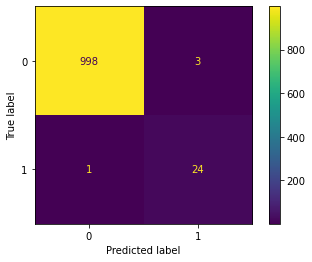

In [67]:
y_pred = best_model.predict_proba(X_test)
y_pred_c = best_model.predict(X_test)
y_test = y_test

print('------------------------------------TESTING INFO-------------------------------------------------')

print(f'F1 on test - {f1_score(y_test, y_pred_c)}')
print(f'precision on test - {precision_score(y_test, y_pred_c)}')
print(f'recall on test - {recall_score(y_test, y_pred_c)}')

cm = confusion_matrix(y_test, y_pred_c, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

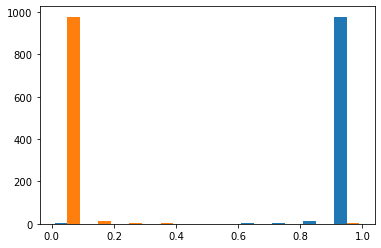

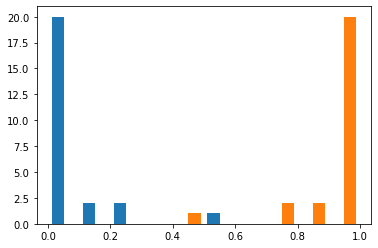

In [68]:
plt.hist(y_pred[y_test==0])
plt.show()
plt.hist(y_pred[y_test==1])
plt.show()

**Комментарии:** 
- наша модель вполне неплохо справляется с классификацией вредоносных смарконтактов
- есть ошибки (FP и FN) , но они низкочастотные (0,3% от общей выборки теста) 
- важно также обратить внимание, что даже при наличии дисбаланса, классы неплохо получается отделять на тесте 
- F1 on test - 0.9230, что хорошо тк у нас высокие показатели и по покрытию (реколл), и по точности
- Несмотря на это, точность (precision on test - 0.88)  несколько ниже значений покрытия на тест (recall on test - 0.96), что объясняется и +- согласуется с нашей бизнес логикой - нам не страшно потерять в точности тк первым приоритетом стоит факт обнаружения вредоносного смарт конракта - FP допустимы в небольшом кол-ве, что мы и наблюдаем на тесте


## 4. Сохраняем модель

In [54]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [55]:
#Проверка, что файл рабочий

loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample', RandomOverSampler(random_state=42)),
                ('model', LogisticRegression(C=100, solver='liblinear'))])